In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pathlib 
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

import PT_files.save_load as sl
from DnCNN_NP.layers  import relu

import time 
from collections import OrderedDict
import pdb

# **Testing the `im2col` MATLAB function. Want to see if it's faster and then see if the results are any better...**

Might be interesting to look at the [numpy-ml package](https://github.com/ddbourgin/numpy-ml/blob/master/numpy_ml/neural_nets/utils/utils.py) to see how they create a 2D Convolution layer.

- They take inspiration from Andrej Karpathy's `im2col.py` file which can be found in these [slides here](http://cs231n.stanford.edu/slides/2016/winter1516_lecture11.pdf). 

- An article that I believe talks about the speed of `im2col.py` is [linked here](https://petewarden.com/2015/04/20/why-gemm-is-at-the-heart-of-deep-learning/). Need to read.

- Lastly, there's a nice package that implements convolutions in a slow (ie. nested for loops) and a fast way (ie. uses im2col idea). Seems like it's fast? That's linked [here](https://github.com/3outeille/CNNumpy/blob/master/src/slow/layers.py)
    - [Blog post](https://hackmd.io/@machine-learning/blog-post-cnnumpy-slow) discussing the `slow` version 
    - [Blog post](https://hackmd.io/@machine-learning/blog-post-cnnumpy-fast) discussing the `fast` version that uses im2col

# 0. Checking where the change in numpy DnCNN and PyTorch DnCNN comes into play.**

In [2]:
PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
name = '2k_model_bs64_e800_ps50_Adam.pth'

# weights = np.load(DATA / name)
weights = torch.load(str(DATA / name))


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

Shape of test set= (108, 1, 6000, 6000)


In [3]:
def get_indices(input_data, weights_dict, prefix, stride=1, padding=1):
    
    # Get input size
    
    # Checking to see if a single sample or a batch of samples is given.
    # If batch take the batch_size, in_channels, H, and W
    # If single sample is given reshape so the values above can be calculated
    if len(input_data.shape) == 4:
    
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    elif len(input_data.shape) == 3:
        
        input_data = input_data.reshape((1, 1, 2000 , 2000))
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    # Load the weights and biases needed for a convolution
    # then take off gpu memory, move to CPU memory,
    # and lastly transform to numpy
    weight = weights_dict[str(prefix) + 'weight']
    weight = weight.detach().cpu().numpy()
    
    bias = weights_dict[str(prefix) + 'bias']
    bias = bias.detach().cpu().numpy()
    
    # Calculate the kernel size and output channels from
    # the loaded weights from above
    kernel_size = weight[0][0].shape
    output_channels = len(weight)
    
    # Calculations for the output H and W dimensions
    height_out = ((height + (2*padding) - (kernel_size[0] - 1) - 1) / stride) + 1
    height_out = int(height_out)
    width_out = ((width + (2*padding) - (kernel_size[1] - 1) - 1) / stride) + 1
    width_out = int(width_out)
    
    
    # ----Compute matrix of index i----

    # Level 1 vector.
    level1 = np.repeat(np.arange(kernel_size[0]), kernel_size[1])
    # Duplicate for the other channels.
    level1 = np.tile(level1, input_channels)
    # Create a vector with an increase by 1 at each level.
    everyLevels = stride * np.repeat(np.arange(height_out), width_out)
    # Create matrix of index i at every levels for each channel.
    i = level1.reshape(-1, 1) + everyLevels.reshape(1, -1)
    
    # ----Compute matrix of index j----
    
    # Slide 1 vector.
    slide1 = np.tile(np.arange(kernel_size[1]), kernel_size[0])
    # Duplicate for the other channels.
    slide1 = np.tile(slide1, input_channels)
    # Create a vector with an increase by 1 at each slide.
    everySlides = stride * np.tile(np.arange(width_out), height_out)
    # Create matrix of index j at every slides for each channel.
    j = slide1.reshape(-1, 1) + everySlides.reshape(1, -1)
    
    # ----Compute matrix of index d----

    # This is to mark delimitation for each channel
    # during multi-dimensional arrays indexing.
    d = np.repeat(np.arange(input_channels), kernel_size[0] * kernel_size[1]).reshape(-1, 1)
    
    return i, j, d

def im2col(input_data, weights_dict, prefix, stride=1, padding=1):
    """
        Transforms our input image into a matrix.

        Parameters:
        - X: input image.
        - HF: filter height.
        - WF: filter width.
        - stride: stride value.
        - pad: padding value.

        Returns:
        -cols: output matrix.
    """
    
    if len(input_data.shape) == 4:
    
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    elif len(input_data.shape) == 3:
        
        input_data = input_data.reshape((1, 1, 2000 , 2000))
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)

    # Padding
    input_padded = np.pad(input_data, ((0,0), (0,0), (padding, padding), (padding, padding)), mode='constant')
    i, j, d = get_indices(input_data=input_data, weights_dict=weights_dict, prefix=prefix)
    # Multi-dimensional arrays indexing.
    cols = input_padded[:, d, i, j]
    cols = np.concatenate(cols, axis=-1)
    return cols

def np_Conv2d(input_data, weights_dict, prefix):
    """
        Performs a forward convolution.

        Parameters:
        - X : Last conv layer of shape (m, n_C_prev, n_H_prev, n_W_prev).
        Returns:
        - out: previous layer convolved.
    """
    
    conv_start = time.perf_counter()
    if len(input_data.shape) == 4:
    
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    elif len(input_data.shape) == 3:
        
        input_data = input_data.reshape((1, 1, 2000 , 2000))
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)


    output_channels = len(weights_dict[str(prefix) + 'weight']) # num_of_filters
    height_out = int((height + 2 * 1 - 3)/ 1) + 1
    width_out = int((width + 2 * 1 - 3)/ 1) + 1

    X_col = im2col(input_data=input_data, weights_dict=weights_dict, prefix=prefix)
    w_col = weights_dict[str(prefix) + 'weight'].detach().cpu().numpy().reshape((output_channels, -1))
    b_col = weights_dict[str(prefix) + 'bias'].detach().cpu().numpy().reshape(-1, 1)
    # Perform matrix multiplication.
    out = w_col @ X_col + b_col
    # Reshape back matrix to image.
    out = np.array(np.hsplit(out, batch_size)).reshape((batch_size, output_channels, height_out, width_out))
    
    conv_end = time.perf_counter()
    print('Conv takes', conv_end-conv_start, 'seconds')
    return out

def np_BatchNorm2d(x, weights_dict, prefix, epsilon=1e-5):
    """
    Computes the batch normalized version of the input.
    
    This function implements a BatchNorm2d from PyTorch. A caveat to
    remember is that this implementation is equivalent to nn.BatchNorm2d
    in `model.eval()` mode. Batch normalization renormalizes the input 
    to the layer to a more parsable data range.
    
    Parameters:
    -----------
    x: numpy.ndarray
        Input image data.
    mean: numpy.ndarray
        Running mean of the dataset, computed during training.
    var: numpy.ndarray
        Running variance of the dataset, computed during training.
    beta: numpy.ndarray
        Offset value added to the normalized output.
        (These are the biases from the model parameter dictionary).
    gamma: numpy.ndarray
        Scale value to rescale the normalzied output.
        (These are the weights from the model parameter dictionary).
    epsilon: float
        Small constant for numerical stability. 
        Default = 1e-5.
        
    Returns:
    --------
    numpy.ndarray
        Output of the batch normalization.
        
    Notes:
    ------
    The operation implemented in this function is:
    
    .. math:: \\frac{\gamma (x - \mu)}{\sigma + \epsilon} + \\beta
    
    where :math:`\mu` is the running mean of the dataset and :math:`\sigma` is
    the running variance of the dataset, both of which are computed during
    training.
    
    For more details and documentation on the PyTorch BatchNorm2d function
    that this function mimics can be found at 
    https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
    """
    batch_start = time.perf_counter()

    gamma = weights_dict[str(prefix) + 'weight'].detach().cpu().numpy().reshape(-1, 1, 1)
    beta = weights_dict[str(prefix) + 'bias'].detach().cpu().numpy().reshape(-1, 1, 1)
    mean = weights_dict[str(prefix) + 'running_mean'].detach().cpu().numpy().reshape(-1, 1, 1).reshape(-1, 1, 1)
    var = weights_dict[str(prefix) + 'running_var'].detach().cpu().numpy().reshape(-1, 1, 1)
    
    output = ((x - mean) / np.sqrt(var + epsilon)) * gamma + beta
    
    batch_end = time.perf_counter()
    print('Batch takes', batch_end-batch_start, 'seconds')
    
    return output

In [4]:
samp = sample[0][0][1000:3000, 1000:3000]
samp = samp.reshape((1, 1, 2000, 2000))

# 1st Layer
conv_out = np_Conv2d(input_data=samp, weights_dict=weights, prefix='layers.0.0.')
out = relu(conv_out)

# Second Layer
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.1.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.1.1.')
out = relu(batch_out)

Conv takes 0.602643136982806 seconds
Conv takes 18.129596814047545 seconds
Batch takes 0.4927177600329742 seconds


In [19]:
test_sample = samp
test_sample = torch.as_tensor(test_sample)
test_sample = test_sample.to(device)
# sample_torch = torch.from_numpy(sample)
# params = OrderedDict({'weight': weights['layers.0.0.weight'], 'bias': weights['layers.0.0.bias']})
params = OrderedDict({'0.weight': weights['layers.0.0.weight'], '0.bias': weights['layers.0.0.bias'], 
                      '2.weight': weights['layers.1.0.weight'], '2.bias': weights['layers.1.0.bias'],
                      '3.weight': weights['layers.1.1.weight'], '3.bias': weights['layers.1.1.weight'],
                      '3.running_mean': weights['layers.1.1.running_mean'], '3.running_var': weights['layers.1.1.running_var'],
                     '3.num_batches_tracked': weights['layers.1.1.num_batches_tracked']})

# model = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding='same') # 1 input channel, 1 output channels, kernelsize=3, stride=1, padding=0
model = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(inplace=True),
                     nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                      nn.BatchNorm2d(num_features=64),
                                        nn.ReLU(inplace=True))#,
                      # nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1))

# params = model.state_dict()
# print(params.keys())
model.to(device)
model.load_state_dict(params)
pytorch_conv_out = model(test_sample)
pytorch_conv_out = pytorch_conv_out.detach().cpu().numpy()

print(np.allclose(out, pytorch_conv_out))

False


In [23]:
print(out.shape)
print(out[0][0][0][:10])

(1, 64, 2000, 2000)
[1.3473446  0.         0.         0.04580524 0.10978375 0.17953369
 0.26026374 0.27005497 0.3315005  0.31939438]


In [24]:
print(pytorch_conv_out.shape)
print(pytorch_conv_out[0][0][0][:10])

(1, 64, 2000, 2000)
[2.4256632 0.5664626 1.1098543 1.1613108 1.222827  1.290285  1.3688896
 1.3789858 1.4385104 1.4264259]


# **1.Testing Whole Model**

In [2]:
def get_indices(input_data, weights_dict, prefix, stride=1, padding=1):
    
    # Get input size
    
    # Checking to see if a single sample or a batch of samples is given.
    # If batch take the batch_size, in_channels, H, and W
    # If single sample is given reshape so the values above can be calculated
    if len(input_data.shape) == 4:
    
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    elif len(input_data.shape) == 3:
        
        input_data = input_data.reshape((1, 1, 2000 , 2000))
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    # Load the weights and biases needed for a convolution
    # then take off gpu memory, move to CPU memory,
    # and lastly transform to numpy
    weight = weights_dict[str(prefix) + 'weight']
    weight = weight.detach().cpu().numpy()
    
    bias = weights_dict[str(prefix) + 'bias']
    bias = bias.detach().cpu().numpy()
    
    # Calculate the kernel size and output channels from
    # the loaded weights from above
    kernel_size = weight[0][0].shape
    output_channels = len(weight)
    
    # Calculations for the output H and W dimensions
    height_out = ((height + (2*padding) - (kernel_size[0] - 1) - 1) / stride) + 1
    height_out = int(height_out)
    width_out = ((width + (2*padding) - (kernel_size[1] - 1) - 1) / stride) + 1
    width_out = int(width_out)
    
    
    # ----Compute matrix of index i----

    # Level 1 vector.
    level1 = np.repeat(np.arange(kernel_size[0]), kernel_size[1])
    # Duplicate for the other channels.
    level1 = np.tile(level1, input_channels)
    # Create a vector with an increase by 1 at each level.
    everyLevels = stride * np.repeat(np.arange(height_out), width_out)
    # Create matrix of index i at every levels for each channel.
    i = level1.reshape(-1, 1) + everyLevels.reshape(1, -1)
    
    # ----Compute matrix of index j----
    
    # Slide 1 vector.
    slide1 = np.tile(np.arange(kernel_size[1]), kernel_size[0])
    # Duplicate for the other channels.
    slide1 = np.tile(slide1, input_channels)
    # Create a vector with an increase by 1 at each slide.
    everySlides = stride * np.tile(np.arange(width_out), height_out)
    # Create matrix of index j at every slides for each channel.
    j = slide1.reshape(-1, 1) + everySlides.reshape(1, -1)
    
    # ----Compute matrix of index d----

    # This is to mark delimitation for each channel
    # during multi-dimensional arrays indexing.
    d = np.repeat(np.arange(input_channels), kernel_size[0] * kernel_size[1]).reshape(-1, 1)
    
    return i, j, d

def im2col(input_data, weights_dict, prefix, stride=1, padding=1):
    """
        Transforms our input image into a matrix.

        Parameters:
        - X: input image.
        - HF: filter height.
        - WF: filter width.
        - stride: stride value.
        - pad: padding value.

        Returns:
        -cols: output matrix.
    """
    
    if len(input_data.shape) == 4:
    
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    elif len(input_data.shape) == 3:
        
        input_data = input_data.reshape((1, 1, 2000 , 2000))
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)

    # Padding
    input_padded = np.pad(input_data, ((0,0), (0,0), (padding, padding), (padding, padding)), mode='constant')
    i, j, d = get_indices(input_data=input_data, weights_dict=weights_dict, prefix=prefix)
    # Multi-dimensional arrays indexing.
    cols = input_padded[:, d, i, j]
    cols = np.concatenate(cols, axis=-1)
    return cols

def np_Conv2d(input_data, weights_dict, prefix):
    """
        Performs a forward convolution.

        Parameters:
        - X : Last conv layer of shape (m, n_C_prev, n_H_prev, n_W_prev).
        Returns:
        - out: previous layer convolved.
    """
    if len(input_data.shape) == 4:
    
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    elif len(input_data.shape) == 3:
        
        input_data = input_data.reshape((1, 1, 2000 , 2000))
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)


    output_channels = len(weights_dict[str(prefix) + 'weight']) # num_of_filters
    height_out = int((height + 2 * 1 - 3)/ 1) + 1
    width_out = int((width + 2 * 1 - 3)/ 1) + 1

    X_col = im2col(input_data=input_data, weights_dict=weights_dict, prefix=prefix)
    w_col = weights_dict[str(prefix) + 'weight'].detach().cpu().numpy().reshape((output_channels, -1))
    b_col = weights_dict[str(prefix) + 'bias'].detach().cpu().numpy().reshape(-1, 1)
    # Perform matrix multiplication.
    out = w_col @ X_col + b_col
    # Reshape back matrix to image.
    out = np.array(np.hsplit(out, batch_size)).reshape((batch_size, output_channels, height_out, width_out))
    
    return out

def np_BatchNorm2d(input_data, prefix, weights_dict, epsilon=1e-5):
    
    x = input_data
    
    gamma = weights_dict[str(prefix) + 'weight'].detach().cpu().numpy().reshape(-1, 1, 1)
    beta = weights_dict[str(prefix) + 'bias'].detach().cpu().numpy().reshape(-1, 1, 1)
    mean = weights_dict[str(prefix) + 'running_mean'].detach().cpu().numpy().reshape(-1, 1, 1)
    var = weights_dict[str(prefix) + 'running_var'].detach().cpu().numpy().reshape(-1, 1, 1)
        
        
    output = ((x - mean) / np.sqrt(var + epsilon)) * gamma + beta
    return output

In [3]:
PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
name = '2k_model_bs64_e800_ps50_Adam.pth'

# weights = np.load(DATA / name)
weights = torch.load(str(DATA / name))


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

Shape of test set= (108, 1, 6000, 6000)


In [4]:
samp = sample[0][0][1000:3000, 1000:3000]
samp = samp.reshape((1, 1, 2000, 2000))

In [5]:
# DnCNN Model

# 1st layer block
conv_out = np_Conv2d(input_data=samp, weights_dict=weights, prefix='layers.0.0.')
out = relu(conv_out)
print(1)

# 2nd layer block
conv_out = np_Conv2d(input_data=conv_out, weights_dict=weights, prefix='layers.1.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.1.1.')
out = relu(batch_out)
print(2)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.2.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.2.1.')
out = relu(batch_out)
print(3)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.3.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.3.1.')
out = relu(batch_out)
print(4)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.4.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.4.1.')
out = relu(batch_out)
print(5)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.5.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.5.1.')
out = relu(batch_out)
print(6)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.6.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.6.1.')
out = relu(batch_out)
print(7)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.7.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.7.1.')
out = relu(batch_out)
print(8)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.8.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.8.1.')
out = relu(batch_out)
print(9)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.9.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.9.1.')
out = relu(batch_out)
print(10)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.10.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.10.1.')
out = relu(batch_out)
print(11)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.11.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.11.1.')
out = relu(batch_out)
print(12)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.12.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.12.1.')
out = relu(batch_out)
print(13)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.13.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.13.1.')
out = relu(batch_out)
print(14)


# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.14.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.14.1.')
out = relu(batch_out)
print(15)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.15.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.15.1.')
out = relu(batch_out)
print(16)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.16.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.16.1.')
out = relu(batch_out)
print(17)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.17.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.17.1.')
out = relu(batch_out)
print(18)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.18.0.')
batch_out = np_BatchNorm2d(input_data=conv_out, weights_dict=weights, prefix='layers.18.1.')
out = relu(batch_out)
print(19)

# Last layer
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.19.')
print(20)

resid_img = samp - conv_out

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


Text(0.5, 1.0, 'Numpy Denoised Image')

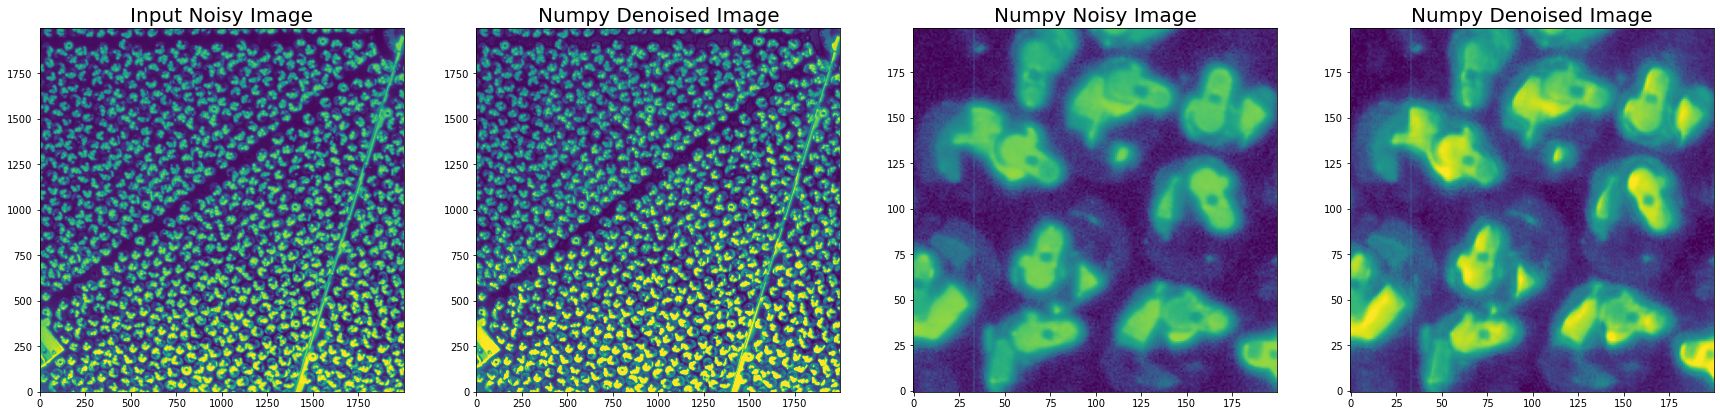

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(30, 26))
vmin, vmax = np.percentile(samp[0][0], (1,99))

axes[0].imshow(samp[0][0], vmin=vmin, vmax=vmax, origin='lower')
axes[0].set_title('Input Noisy Image', fontsize=20)
axes[1].imshow(resid_img[0][0],vmin=vmin, vmax=vmax, origin='lower')
axes[1].set_title('Numpy Denoised Image', fontsize=20)
axes[2].imshow(samp[0][0][1000:1200,1000:1200], vmin=vmin, vmax=vmax,origin='lower')
axes[2].set_title('Numpy Noisy Image', fontsize=20)
axes[3].imshow(resid_img[0][0][1000:1200,1000:1200], vmin=vmin, vmax=vmax,origin='lower')
axes[3].set_title('Numpy Denoised Image', fontsize=20)

In [7]:
def grid_window(dataset,
                model,
                model_params,
                samp_idx,
                h_start,
                h_end,
                w_start,
                w_end):
    
    """
    Function to calculate a specified sized inference window.
    
    Parameters:
    -----------
    dataset: np.array
        Dataset of coupled noisy & clean images of full 6k images
    model: Pytorch model
        DnCNN
    model_params: str
        Models parameters for the 2k image trained model
    samp_idx: int
        Sample index to select which of the test images to be used for 
        inference
    h_start: int
        The height starting index of the inference window.
        E.g. It would be the origin for the y-coord in a 2-D plot
    h_end: int
        The height ending index of the inference window.
        E.g. It would be the end of the y-axis for the y-coord 
        in a 2-D plot
    w_start: int
        The horizontal starting index of the inference window.
        E.g. It would be the origin for the x-coord in a 2-D plot
    w_end: int
        The horizontal ending index of the inference window.
        E.g. It would be the end of the x-axis for the x-coord 
        in a 2-D plot
   
        
    Returns:
    --------
    full: np.array
        Array of the models output over the window region.
    count: np.array
        Array of 1's that keeps track of which pixels have had
        inferenced done upon them. This is so later on averaging can
        be done for pixels that had overlapping inference window
        calculations.
    """
    
    full = np.empty((1, 1, 6000, 6000))
    count = np.empty((1, 1, 6000, 6000))
    
    noise_data = dataset[0]
    params_name = model_params
    
    current_dir = pathlib.Path().resolve()
    model_params_path = current_dir / 'Model_params'
    assert model_params_path.exists()
    model_path = model_params_path / params_name
    print('Check pt 1')
    
    model = model()
    model.to(device)
    model.load_state_dict(torch.load(str(model_path)))
    model.eval()
    print('Check pt 2')

    
    with torch.no_grad():
                
        torch.cuda.empty_cache()
        test_noise = torch.as_tensor(noise_data[samp_idx:samp_idx+1, :, h_start:h_end, w_start:w_end])
        test_noise = test_noise.to(device)
        print('Check pt 3')

        
        output = model(test_noise)
        resid_img = output.detach().cpu().numpy()
        print('Check pt 4')
        
        test_noise.detach().cpu()
        torch.cuda.empty_cache()
        del test_noise
        
        full[:, :, h_start:h_end, w_start:w_end] += resid_img
        count[:, :, h_start:h_end, w_start:w_end] += 1
        
        torch.cuda.empty_cache()
        del resid_img
        print('Run finished')
        
        
    return full, count

In [8]:
from PT_files.model import DnCNN

full_c1, count_c1 = grid_window(dataset=test_data,
                                        model=DnCNN,
                                        model_params="2k_model_bs64_e800_ps50_Adam.pth",
                                        samp_idx=0,
                                        h_start=1000,
                                        h_end=3000,
                                        w_start=1000,
                                        w_end=3000)

Using cuda device
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished


In [9]:
pytorch = full_c1[0][0][1000:3000, 1000:3000]
pytorch_out = np.reshape(pytorch, (1, 1, 2000, 2000))

Text(0.5, 1.0, 'Pytorch Denoised Image')

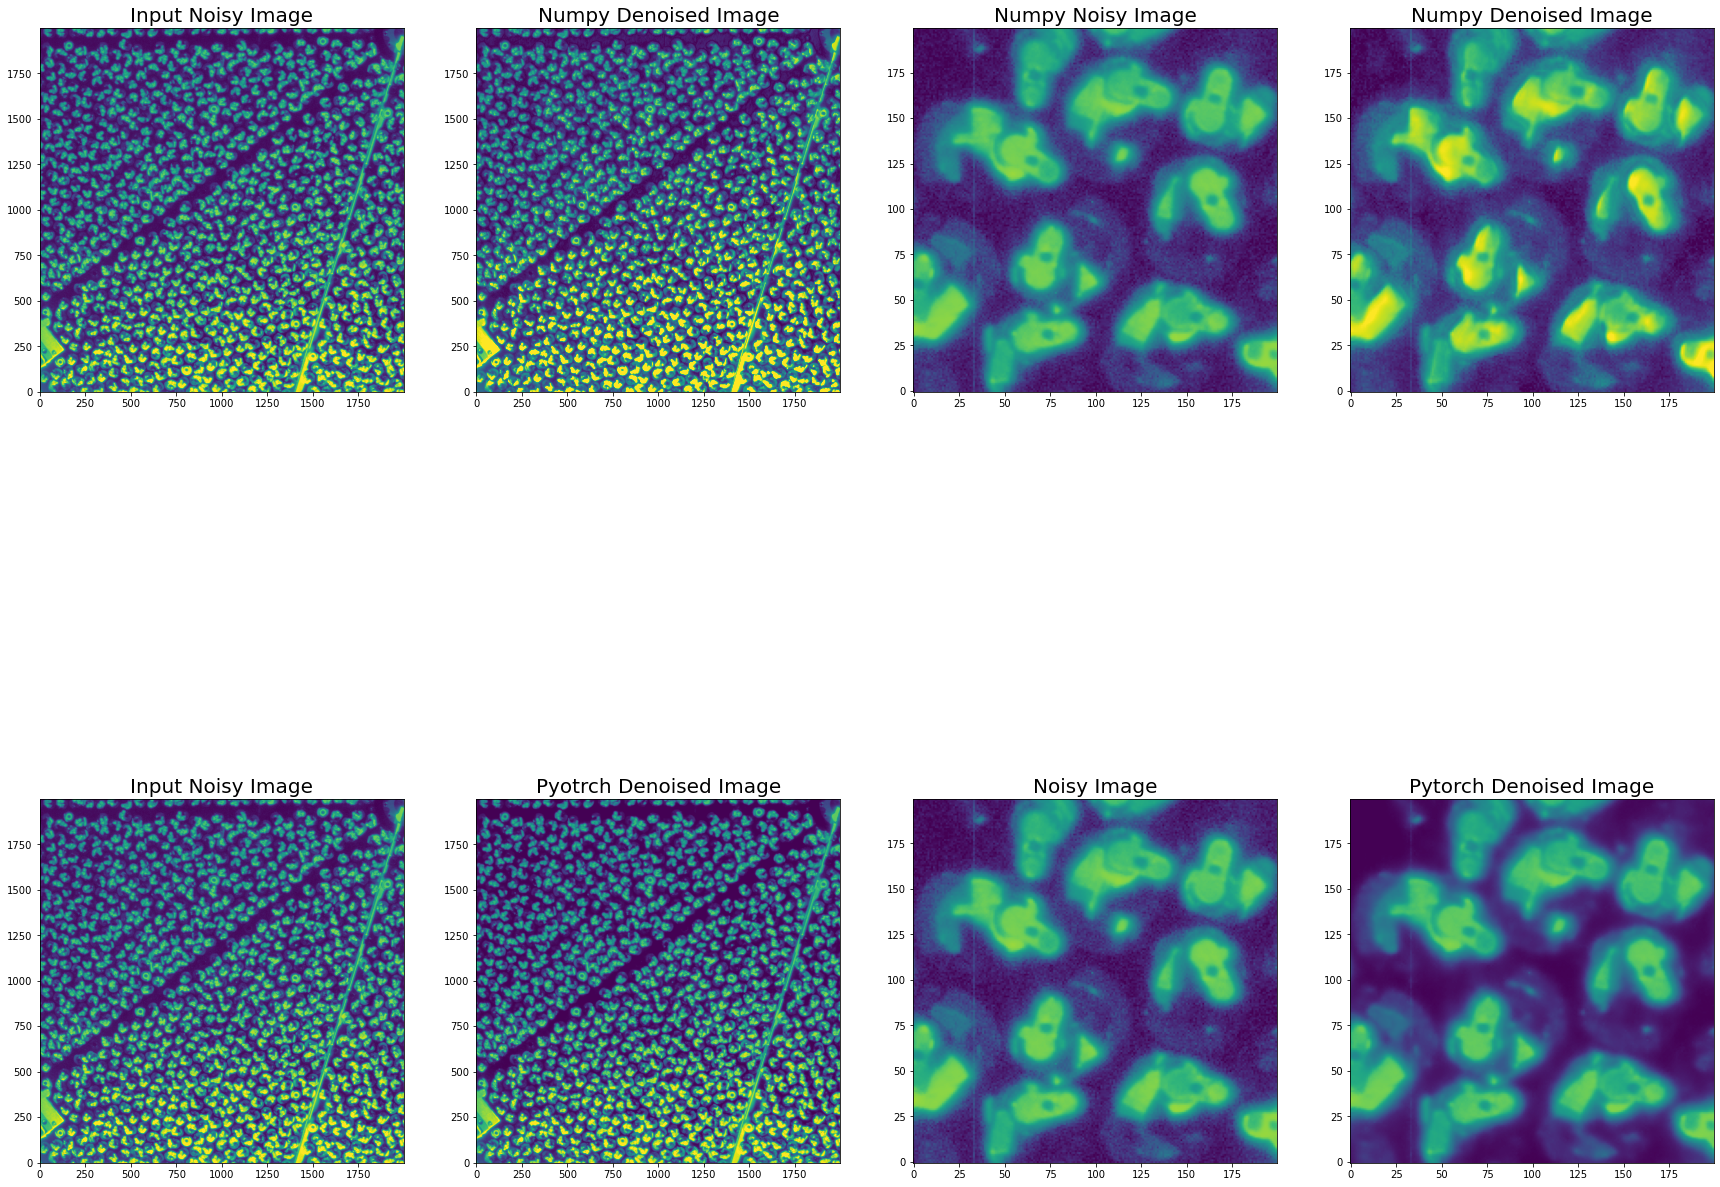

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(30, 26))
vmin, vmax = np.percentile(samp[0][0], (1,99))

axes[0,0].imshow(samp[0][0], vmin=vmin, vmax=vmax, origin='lower')
axes[0,0].set_title('Input Noisy Image', fontsize=20)
axes[0,1].imshow(resid_img[0][0],vmin=vmin, vmax=vmax, origin='lower')
axes[0,1].set_title('Numpy Denoised Image', fontsize=20)
axes[0,2].imshow(samp[0][0][1000:1200,1000:1200], vmin=vmin, vmax=vmax,origin='lower')
axes[0,2].set_title('Numpy Noisy Image', fontsize=20)
axes[0,3].imshow(resid_img[0][0][1000:1200,1000:1200], vmin=vmin, vmax=vmax,origin='lower')
axes[0,3].set_title('Numpy Denoised Image', fontsize=20)

axes[1,0].imshow(samp[0][0], vmin=vmin, vmax=vmax, origin='lower')
axes[1,0].set_title('Input Noisy Image', fontsize=20)
axes[1,1].imshow(pytorch_out[0][0],vmin=vmin, vmax=vmax, origin='lower')
axes[1,1].set_title('Pyotrch Denoised Image', fontsize=20)
axes[1,2].imshow(samp[0][0][1000:1200,1000:1200], vmin=vmin, vmax=vmax,origin='lower')
axes[1,2].set_title('Noisy Image', fontsize=20)
axes[1,3].imshow(pytorch_out[0][0][1000:1200,1000:1200], vmin=vmin, vmax=vmax,origin='lower')
axes[1,3].set_title('Pytorch Denoised Image', fontsize=20)

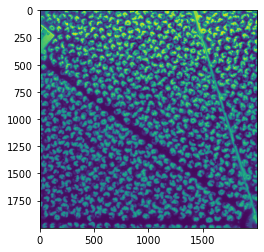

In [11]:
plt.imshow(pytorch_out[0][0])

In [13]:
np.allclose(full_c1[0][0][1000:3000, 1000:3000], resid_img)

False